In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES_LEVEL2 = 17

# Mapping subkategori ke organik/anorganik (0: Organik, 1: Anorganik)
subkategori_ke_level1 = [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]

# Mapping label ke nama kelas
label_level2_map = {
    0: 'Cangkang Telur', 1: 'Elektronik', 2: 'Kaca', 3: 'Kain', 4: 'Kardus', 5: 'Karet',
    6: 'Kayu', 7: 'Kertas', 8: 'Kotoran Hewan', 9: 'Logam', 10: 'Plastik', 11: 'Sepatu',
    12: 'Sisa Buah', 13: 'Sisa Teh Kopi', 14: 'Sisa makanan', 15: 'Styrofoam', 16: 'Tumbuhan'
}

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = r'C:\Users\muham\OneDrive\Documents\KULIAH SEMESTER 6\KP\Project KP\Dataset Beneran\train'
val_dir = r'C:\Users\muham\OneDrive\Documents\KULIAH SEMESTER 6\KP\Project KP\Dataset Beneran\val'

train_gen_base = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
val_gen_base = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 8260 images belonging to 17 classes.
Found 2055 images belonging to 17 classes.


In [ ]:
def multi_output_generator(generator):
    while True:
        x, y_level2 = next(generator)
        y_indices = np.argmax(y_level2, axis=1)
        y_level1 = np.array([subkategori_ke_level1[idx] for idx in y_indices]).reshape(-1, 1)
        yield x, {'level1': y_level1, 'level2': y_level2}

train_gen = multi_output_generator(train_gen_base)
val_gen = multi_output_generator(val_gen_base)

In [ ]:
input_layer = Input(shape=(224, 224, 3))
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

level1_output = Dense(1, activation='sigmoid', name='level1')(x)
level2_output = Dense(NUM_CLASSES_LEVEL2, activation='softmax', name='level2')(x)

model = Model(inputs=input_layer, outputs=[level1_output, level2_output])
model.compile(
    optimizer='adam',
    loss={'level1': 'binary_crossentropy', 'level2': 'categorical_crossentropy'},
    metrics={'level1': 'accuracy', 'level2': 'accuracy'}
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 26, 26,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 86528)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 86528)     │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level1 (Dense)      │ (None, 1)         │     86,529 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level2 (Dense)      │ (None, 17)        │  1,470,993 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,650,770 (6.30 MB)

 Trainable params: 1,650,770 (6.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 50
steps_per_epoch = train_gen_base.samples // BATCH_SIZE
validation_steps = val_gen_base.samples // BATCH_SIZE

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
model_ckpt = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[early_stop, model_ckpt]
)

Epoch 1/50
 59/258 ━━━━━━━━━━━━━━━━━━━━ 3:46 1s/step - level1_accuracy: 0.6187 - level1_loss: 0.6944 - level2_accuracy: 0.1049 - level2_loss: 2.8488 - loss: 3.5432

c:\Users\muham\anaconda3\envs\tfenv\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - level1_accuracy: 0.6976 - level1_loss: 0.5901 - level2_accuracy: 0.1631 - level2_loss: 2.6108 - loss: 3.2008

258/258 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - level1_accuracy: 0.6978 - level1_loss: 0.5898 - level2_accuracy: 0.1633 - level2_loss: 2.6100 - loss: 3.1998 - val_level1_accuracy: 0.7793 - val_level1_loss: 0.4924 - val_level2_accuracy: 0.3169 - val_level2_loss: 2.0957 - val_loss: 2.5881
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 188s 732ms/step - level1_accuracy: 0.7784 - level1_loss: 0.4733 - level2_accuracy: 0.3114 - level2_loss: 2.1387 - loss: 2.5974 - val_level1_accuracy: 0.7700 - val_level1_loss: 0.4927 - val_level2_accuracy: 0.3408 - val_level2_loss: 2.1425 - val_loss: 2.6352
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - level1_accuracy: 0.7853 - level1_loss: 0.4755 - level2_accuracy: 0.3642 - level2_loss: 1.9816 - loss: 2.4366

258/258 ━━━━━━━━━━━━━━━━━━━━ 184s 712ms/step - level1_accuracy: 0.7853 - level1_loss: 0.4754 - level2_accuracy: 0.3642 - level2_loss: 1.9815 - loss: 2.4365 - val_level1_accuracy: 0.8032 - val_level1_loss: 0.4425 - val_level2_accuracy: 0.4072 - val_level2_loss: 1.8861 - val_loss: 2.3286
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - level1_accuracy: 0.8051 - level1_loss: 0.4255 - level2_accuracy: 0.4312 - level2_loss: 1.8159 - loss: 2.2566

258/258 ━━━━━━━━━━━━━━━━━━━━ 184s 714ms/step - level1_accuracy: 0.8051 - level1_loss: 0.4255 - level2_accuracy: 0.4312 - level2_loss: 1.8159 - loss: 2.2566 - val_level1_accuracy: 0.8112 - val_level1_loss: 0.4094 - val_level2_accuracy: 0.4642 - val_level2_loss: 1.7273 - val_loss: 2.1424
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - level1_accuracy: 0.8102 - level1_loss: 0.4218 - level2_accuracy: 0.4182 - level2_loss: 1.7893 - loss: 2.2106

258/258 ━━━━━━━━━━━━━━━━━━━━ 184s 713ms/step - level1_accuracy: 0.8102 - level1_loss: 0.4218 - level2_accuracy: 0.4183 - level2_loss: 1.7892 - loss: 2.2104 - val_level1_accuracy: 0.8176 - val_level1_loss: 0.4108 - val_level2_accuracy: 0.4760 - val_level2_loss: 1.7225 - val_loss: 2.1248
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - level1_accuracy: 0.8189 - level1_loss: 0.4015 - level2_accuracy: 0.4370 - level2_loss: 1.7490 - loss: 2.1383

258/258 ━━━━━━━━━━━━━━━━━━━━ 179s 694ms/step - level1_accuracy: 0.8189 - level1_loss: 0.4015 - level2_accuracy: 0.4370 - level2_loss: 1.7490 - loss: 2.1383 - val_level1_accuracy: 0.8260 - val_level1_loss: 0.3781 - val_level2_accuracy: 0.5002 - val_level2_loss: 1.5942 - val_loss: 1.9729
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 177s 689ms/step - level1_accuracy: 0.8241 - level1_loss: 0.3793 - level2_accuracy: 0.4713 - level2_loss: 1.6549 - loss: 2.0384 - val_level1_accuracy: 0.8300 - val_level1_loss: 0.3900 - val_level2_accuracy: 0.4909 - val_level2_loss: 1.6600 - val_loss: 2.0559
Epoch 8/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - level1_accuracy: 0.8257 - level1_loss: 0.3776 - level2_accuracy: 0.4740 - level2_loss: 1.6359 - loss: 2.0238

258/258 ━━━━━━━━━━━━━━━━━━━━ 178s 690ms/step - level1_accuracy: 0.8257 - level1_loss: 0.3776 - level2_accuracy: 0.4740 - level2_loss: 1.6359 - loss: 2.0238 - val_level1_accuracy: 0.8418 - val_level1_loss: 0.3621 - val_level2_accuracy: 0.5210 - val_level2_loss: 1.5263 - val_loss: 1.8905
Epoch 9/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 188s 729ms/step - level1_accuracy: 0.8267 - level1_loss: 0.3841 - level2_accuracy: 0.4706 - level2_loss: 1.6237 - loss: 2.0057 - val_level1_accuracy: 0.8458 - val_level1_loss: 0.3580 - val_level2_accuracy: 0.5388 - val_level2_loss: 1.5391 - val_loss: 1.8992
Epoch 10/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - level1_accuracy: 0.8285 - level1_loss: 0.3862 - level2_accuracy: 0.4801 - level2_loss: 1.6150 - loss: 1.9909

258/258 ━━━━━━━━━━━━━━━━━━━━ 238s 925ms/step - level1_accuracy: 0.8285 - level1_loss: 0.3861 - level2_accuracy: 0.4802 - level2_loss: 1.6148 - loss: 1.9907 - val_level1_accuracy: 0.8542 - val_level1_loss: 0.3299 - val_level2_accuracy: 0.5487 - val_level2_loss: 1.4829 - val_loss: 1.8082
Epoch 11/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 236s 916ms/step - level1_accuracy: 0.8329 - level1_loss: 0.3800 - level2_accuracy: 0.4831 - level2_loss: 1.6029 - loss: 1.9677 - val_level1_accuracy: 0.8517 - val_level1_loss: 0.3447 - val_level2_accuracy: 0.5556 - val_level2_loss: 1.4814 - val_loss: 1.8258
Epoch 12/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 237s 921ms/step - level1_accuracy: 0.8510 - level1_loss: 0.3416 - level2_accuracy: 0.5143 - level2_loss: 1.4882 - loss: 1.8307 - val_level1_accuracy: 0.8349 - val_level1_loss: 0.3778 - val_level2_accuracy: 0.5215 - val_level2_loss: 1.6308 - val_loss: 2.0050
Epoch 13/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 240s 933ms/step - level1_accuracy: 0.8458 - level1_loss: 0.3466 - level2_a

258/258 ━━━━━━━━━━━━━━━━━━━━ 243s 942ms/step - level1_accuracy: 0.8311 - level1_loss: 0.3662 - level2_accuracy: 0.5211 - level2_loss: 1.4738 - loss: 1.8475 - val_level1_accuracy: 0.8557 - val_level1_loss: 0.3305 - val_level2_accuracy: 0.5556 - val_level2_loss: 1.4513 - val_loss: 1.7826
Epoch 15/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - level1_accuracy: 0.8511 - level1_loss: 0.3529 - level2_accuracy: 0.5153 - level2_loss: 1.4876 - loss: 1.8458

258/258 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - level1_accuracy: 0.8511 - level1_loss: 0.3529 - level2_accuracy: 0.5153 - level2_loss: 1.4876 - loss: 1.8458 - val_level1_accuracy: 0.8626 - val_level1_loss: 0.3381 - val_level2_accuracy: 0.5640 - val_level2_loss: 1.4288 - val_loss: 1.7677
Epoch 16/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 225s 875ms/step - level1_accuracy: 0.8524 - level1_loss: 0.3356 - level2_accuracy: 0.5334 - level2_loss: 1.4545 - loss: 1.7926 - val_level1_accuracy: 0.8621 - val_level1_loss: 0.3254 - val_level2_accuracy: 0.5576 - val_level2_loss: 1.4541 - val_loss: 1.7811
Epoch 17/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - level1_accuracy: 0.8439 - level1_loss: 0.3525 - level2_accuracy: 0.5208 - level2_loss: 1.5031 - loss: 1.8382

258/258 ━━━━━━━━━━━━━━━━━━━━ 214s 830ms/step - level1_accuracy: 0.8439 - level1_loss: 0.3525 - level2_accuracy: 0.5208 - level2_loss: 1.5030 - loss: 1.8382 - val_level1_accuracy: 0.8769 - val_level1_loss: 0.2929 - val_level2_accuracy: 0.5863 - val_level2_loss: 1.3653 - val_loss: 1.6560
Epoch 18/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 218s 847ms/step - level1_accuracy: 0.8568 - level1_loss: 0.3215 - level2_accuracy: 0.5368 - level2_loss: 1.4492 - loss: 1.7537 - val_level1_accuracy: 0.8769 - val_level1_loss: 0.3124 - val_level2_accuracy: 0.5754 - val_level2_loss: 1.3965 - val_loss: 1.7121
Epoch 19/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - level1_accuracy: 0.8628 - level1_loss: 0.3293 - level2_accuracy: 0.5545 - level2_loss: 1.4148 - loss: 1.7425 - val_level1_accuracy: 0.8566 - val_level1_loss: 0.3366 - val_level2_accuracy: 0.5685 - val_level2_loss: 1.4232 - val_loss: 1.7532
Epoch 20/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 182s 706ms/step - level1_accuracy: 0.8575 - level1_loss: 0.3300 - level2_accu

258/258 ━━━━━━━━━━━━━━━━━━━━ 169s 657ms/step - level1_accuracy: 0.8662 - level1_loss: 0.3033 - level2_accuracy: 0.5693 - level2_loss: 1.3367 - loss: 1.6497 - val_level1_accuracy: 0.8819 - val_level1_loss: 0.2837 - val_level2_accuracy: 0.6189 - val_level2_loss: 1.2622 - val_loss: 1.5416
Epoch 24/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 221s 858ms/step - level1_accuracy: 0.8686 - level1_loss: 0.3131 - level2_accuracy: 0.5599 - level2_loss: 1.3689 - loss: 1.6831 - val_level1_accuracy: 0.8641 - val_level1_loss: 0.3242 - val_level2_accuracy: 0.5739 - val_level2_loss: 1.4170 - val_loss: 1.7413
Epoch 25/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 224s 871ms/step - level1_accuracy: 0.8672 - level1_loss: 0.3128 - level2_accuracy: 0.5672 - level2_loss: 1.3462 - loss: 1.6636 - val_level1_accuracy: 0.8606 - val_level1_loss: 0.3313 - val_level2_accuracy: 0.6001 - val_level2_loss: 1.3441 - val_loss: 1.6805
Epoch 26/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 206s 801ms/step - level1_accuracy: 0.8657 - level1_loss: 0.3056 - level2_a

258/258 ━━━━━━━━━━━━━━━━━━━━ 182s 705ms/step - level1_accuracy: 0.8728 - level1_loss: 0.2928 - level2_accuracy: 0.5779 - level2_loss: 1.3191 - loss: 1.6087 - val_level1_accuracy: 0.8814 - val_level1_loss: 0.2791 - val_level2_accuracy: 0.6204 - val_level2_loss: 1.2272 - val_loss: 1.4958
Epoch 32/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 226s 876ms/step - level1_accuracy: 0.8743 - level1_loss: 0.2918 - level2_accuracy: 0.5927 - level2_loss: 1.2732 - loss: 1.5642 - val_level1_accuracy: 0.8754 - val_level1_loss: 0.3100 - val_level2_accuracy: 0.6298 - val_level2_loss: 1.2900 - val_loss: 1.5951
Epoch 33/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 224s 870ms/step - level1_accuracy: 0.8691 - level1_loss: 0.3118 - level2_accuracy: 0.5895 - level2_loss: 1.2916 - loss: 1.5916 - val_level1_accuracy: 0.8937 - val_level1_loss: 0.2712 - val_level2_accuracy: 0.6209 - val_level2_loss: 1.2767 - val_loss: 1.5363
Epoch 34/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - level1_accuracy: 0.8643 - level1_loss: 0.3043 - level2_acc

258/258 ━━━━━━━━━━━━━━━━━━━━ 225s 875ms/step - level1_accuracy: 0.8643 - level1_loss: 0.3042 - level2_accuracy: 0.5893 - level2_loss: 1.2796 - loss: 1.5798 - val_level1_accuracy: 0.8809 - val_level1_loss: 0.2791 - val_level2_accuracy: 0.6446 - val_level2_loss: 1.2005 - val_loss: 1.4766
Epoch 35/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 230s 891ms/step - level1_accuracy: 0.8673 - level1_loss: 0.3088 - level2_accuracy: 0.5854 - level2_loss: 1.2967 - loss: 1.6060 - val_level1_accuracy: 0.8636 - val_level1_loss: 0.3507 - val_level2_accuracy: 0.5848 - val_level2_loss: 1.4628 - val_loss: 1.8080
Epoch 36/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 225s 873ms/step - level1_accuracy: 0.8739 - level1_loss: 0.2869 - level2_accuracy: 0.5965 - level2_loss: 1.2491 - loss: 1.5378 - val_level1_accuracy: 0.8611 - val_level1_loss: 0.3631 - val_level2_accuracy: 0.5868 - val_level2_loss: 1.4728 - val_loss: 1.8279
Epoch 37/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 234s 908ms/step - level1_accuracy: 0.8709 - level1_loss: 0.2985 - level2_a

258/258 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - level1_accuracy: 0.8669 - level1_loss: 0.3044 - level2_accuracy: 0.6055 - level2_loss: 1.2205 - loss: 1.5270 - val_level1_accuracy: 0.8868 - val_level1_loss: 0.2829 - val_level2_accuracy: 0.6594 - val_level2_loss: 1.1702 - val_loss: 1.4503
Epoch 40/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - level1_accuracy: 0.8795 - level1_loss: 0.2847 - level2_accuracy: 0.6007 - level2_loss: 1.2333 - loss: 1.5191 - val_level1_accuracy: 0.8705 - val_level1_loss: 0.3246 - val_level2_accuracy: 0.5892 - val_level2_loss: 1.3404 - val_loss: 1.6594
Epoch 41/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - level1_accuracy: 0.8790 - level1_loss: 0.2899 - level2_accuracy: 0.5964 - level2_loss: 1.2410 - loss: 1.5228 - val_level1_accuracy: 0.8873 - val_level1_loss: 0.2797 - val_level2_accuracy: 0.6510 - val_level2_loss: 1.2066 - val_loss: 1.4801
Epoch 42/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - level1_accuracy: 0.8846 - level1_loss: 0.2809 - level2_accuracy: 0.6

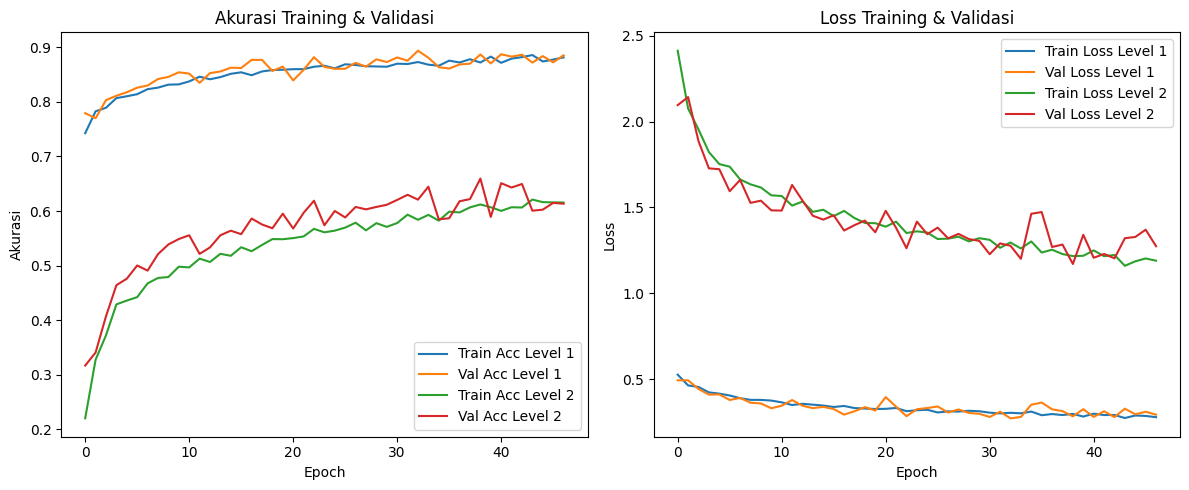

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['level1_accuracy'], label='Train Acc Level 1')
plt.plot(history.history['val_level1_accuracy'], label='Val Acc Level 1')
plt.plot(history.history['level2_accuracy'], label='Train Acc Level 2')
plt.plot(history.history['val_level2_accuracy'], label='Val Acc Level 2')
plt.title('Akurasi Training & Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['level1_loss'], label='Train Loss Level 1')
plt.plot(history.history['val_level1_loss'], label='Val Loss Level 1')
plt.plot(history.history['level2_loss'], label='Train Loss Level 2')
plt.plot(history.history['val_level2_loss'], label='Val Loss Level 2')
plt.title('Loss Training & Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

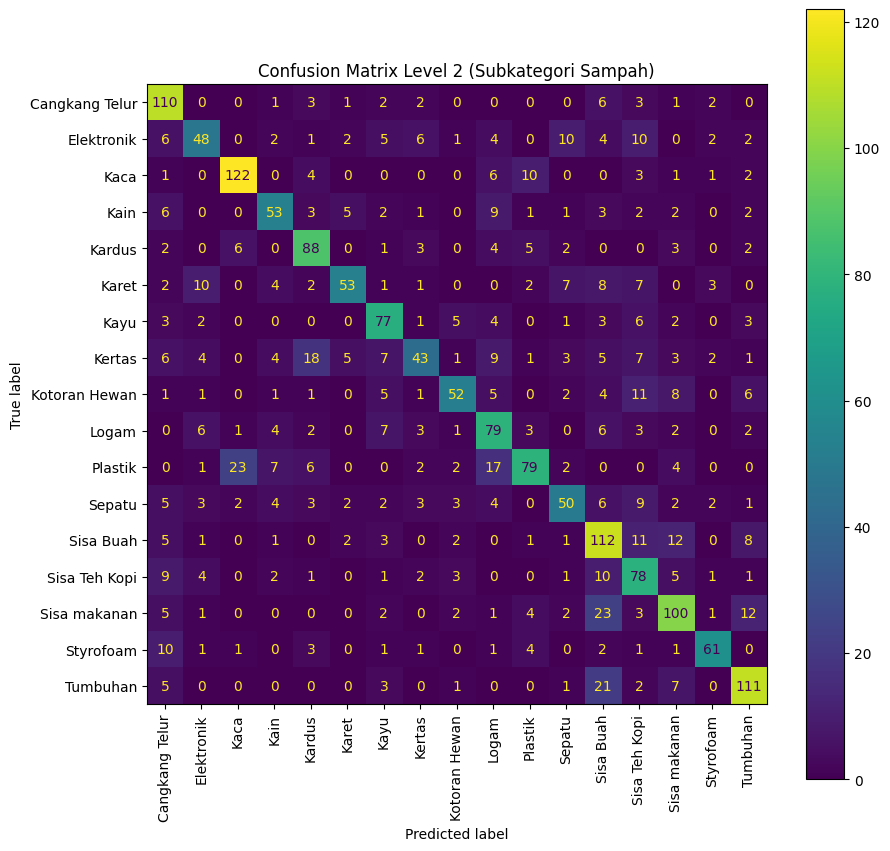

: 

In [ ]:
val_gen_base.reset()
y_true = []
y_pred = []

for _ in range(validation_steps):
    x_batch, y_batch = next(val_gen)
    y_true_indices = np.argmax(y_batch['level2'], axis=1)
    preds = model.predict(x_batch)
    y_pred_indices = np.argmax(preds[1], axis=1)  # output kedua: level2
    y_true.extend(y_true_indices)
    y_pred.extend(y_pred_indices)

labels = [label_level2_map[i] for i in range(NUM_CLASSES_LEVEL2)]
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation='vertical', ax=ax, cmap='viridis')
plt.title("Confusion Matrix Level 2 (Subkategori Sampah)")
plt.show()